In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cytominer_eval import evaluate_metrics

from utils import remove_empty_wells

plt.rcParams["font.family"] = ["Roboto"]
plt.rcParams["font.size"] = 14

In [2]:
bio_map = pd.read_csv("outputs/corum-complex-retrieval-mAP-transformed-profiles-inf-eff_q_threshold.csv.gz")
bio_map

,Metadata_CORUM_protein_complex,mean_average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold
0,12S U11 snRNP,0.006434,0.733807,0.374370,0.426699,False,False
1,14-3-3q-SGK1-tau complex,0.171001,1.734744,0.070946,1.149075,True,False
2,17S U2 snRNP,0.007122,0.365090,0.651214,0.186276,False,False
3,18S U11/U12 snRNP,0.128453,1.750309,0.068959,1.161410,True,False
4,26S proteasome,0.026418,0.927850,0.275945,0.559177,False,False
...,...,...,...,...,...,...,...
1035,"prohibitin 2 complex, mitochondrial",0.000818,0.020774,0.971984,0.012341,False,False
1036,protein complex (DDX28; DHX30; GRSF1; FASTKD2;...,0.032021,1.274217,0.156248,0.806187,False,False
1037,sGNAI2-DRD2 receptor complex,0.004175,0.540458,0.502723,0.298671,False,False
1038,tRNA splicing endonuclease,0.001563,0.313522,0.668328,0.175010,False,False


In [3]:
bio_map.rename({
    "mean_average_precision": "mAP",
    "nlog10pvalue": "-log10(p-value)",
    "nlog10qvalue": "-log10(q-value)",
    "above_p_threshold": "p < 0.05",
    "above_q_threshold": "q < 0.05"
    }, axis=1, inplace=True)
bio_map

,Metadata_CORUM_protein_complex,mAP,-log10(p-value),q_value,-log10(q-value),p < 0.05,q < 0.05
0,12S U11 snRNP,0.006434,0.733807,0.374370,0.426699,False,False
1,14-3-3q-SGK1-tau complex,0.171001,1.734744,0.070946,1.149075,True,False
2,17S U2 snRNP,0.007122,0.365090,0.651214,0.186276,False,False
3,18S U11/U12 snRNP,0.128453,1.750309,0.068959,1.161410,True,False
4,26S proteasome,0.026418,0.927850,0.275945,0.559177,False,False
...,...,...,...,...,...,...,...
1035,"prohibitin 2 complex, mitochondrial",0.000818,0.020774,0.971984,0.012341,False,False
1036,protein complex (DDX28; DHX30; GRSF1; FASTKD2;...,0.032021,1.274217,0.156248,0.806187,False,False
1037,sGNAI2-DRD2 receptor complex,0.004175,0.540458,0.502723,0.298671,False,False
1038,tRNA splicing endonuclease,0.001563,0.313522,0.668328,0.175010,False,False


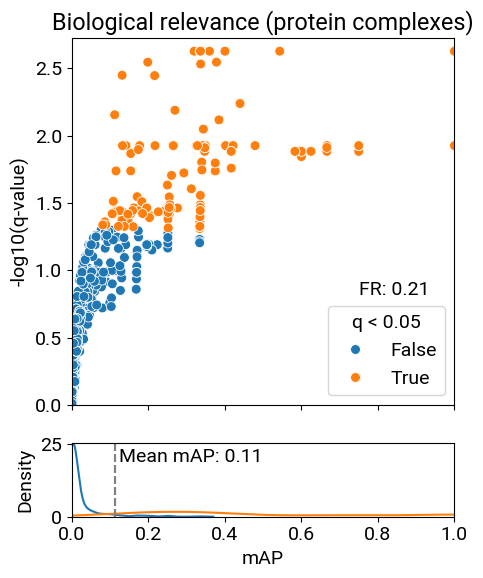

In [8]:
df = bio_map

def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass


fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['q < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(q-value)', 
    hue='q < 0.05',
    s=50
)
axes[0].set_title("Biological similarity (protein complexes)")
axes[0].text(0.75, 0.3, f"FR: {fr:.2f}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(q-value)'])+0.1)
sns.move_legend(axes[0], "lower right")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in df['q < 0.05'].unique():
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['q < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()


In [9]:
bio_map["q < 0.05"].sum()

215